<a href="https://colab.research.google.com/github/GZabalaG/AIMaster/blob/main/Not_Supervised/N1_2_M%C3%A9todos_de_clustering_jer%C3%A1rquico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>N1: Métodos de clustering</h1></center>

# N1.2: Métodos de clustering jerárquico


# RECUERDA RELLENAR TUS DATOS A CONTINUACIÓN ANTES DE HACER NADA

In [57]:
# ===============================================================#
# Rellena AQUÍ tu nombre y apellidos antes de hacer nada
# ===============================================================#

NOMBRE = 'Gonzalo'
APELLIDOS = 'Zabala García'

# ===============================================================#

En esta práctica vamos a ver cómo funcionan los algoritmos jerárquicos vistos en clase: el aglomerativo y el divisivo.

### Clustering jerárquico aglomerativo

En esta práctica estudiaremos el funcionamiento y la utilización del clústering jerárquico aglomerativo.

Para empezar, cargamos las librerías que vamos a necesitar:

In [58]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram
plt.rcParams['figure.figsize'] = [8, 8]


Para comenzar, cargamos el conjunto de datos con el que trabajaremos:


Tamaño de los datos:  (22, 2)


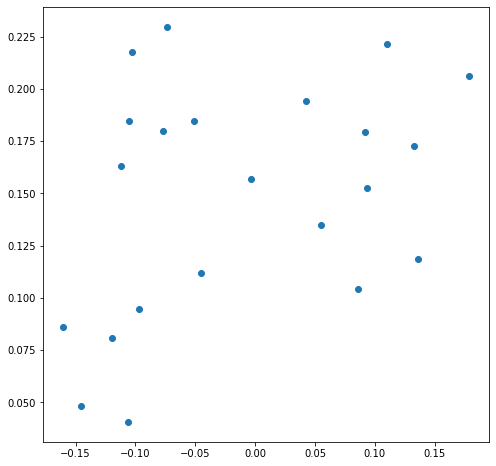

In [59]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_reducido.csv'
Dx = np.array(pd.read_csv(data_file_url,header=0))
Dx = Dx[ np.random.choice(np.arange(Dx.shape[0]), Dx.shape[0], replace=False) ,:]
print('Tamaño de los datos: ', Dx.shape)

plt.scatter(Dx[:,0], Dx[:,1])
plt.show()


Con este dataset trabajaremos y estudiaremos en esta práctica las diferentes variantes del clústering aglomerativo. Para empezar, será necesario calcular la matriz de distancias, por lo que recuperamos de prácticas anteriores la función matriz_distancias.  


In [60]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD


Necesitamos una función que, dada una matriz de distancias, construya un clustering aglomerativo. Es decir, partiendo de n clústeres (uno por ejemplo de entrenamiento), se van uniendo iterativamente dos clústeres (escogidos según minimizan la distancia interclúster definida de acuerdo a cierto criterio) hasta que todos los elementos se agrupan en un único clúster final.

Sabemos que el número de uniones es igual a n-1 (el número de ejemplos menos uno). En la siguiente función, vamos guardando en cada columna de la matriz mParticiones la partición en clústeres de los ejemplos: cada partición mParticiones[:,p], de longitud n, guarda el clúster al que pertenece el i-ésimo ejemplo en la posición mParticiones[i,p]. Para rellenar esa matriz, en cada paso (unión), se calcula la matriz de distancia entre todos los pares de clústeres usando el criterio elegido. Después, simplemente se trata de asignar todos los elementos de los clústeres elegidos a un mismo grupo. Este procedimiento iterativo se repite hasta que sólo queda un clúster en el paso final:


In [61]:
def clustering_aglomerativo(mD, criterio):
    # En esta matriz almacenaremos las sucesivas particiones (clusterings) de los
    # datos. Sucesivas, porque cada paso del bucle de abajo realizará una unión
    # entre los dos clusters más similares, hasta que no queden elementos sueltos.
    mParticiones = np.zeros((mD.shape[0], mD.shape[0]), dtype = np.int8)
    # Rellenamos la última columna con valores del 0 al 21, ya que en este paso 
    # cada elemento pertenecerá a un cluster distinto
    mParticiones[:,21] = np.arange(22)

    # Recorremos `mParticiones` de manera decreciente guardando los agrupamientos,
    # ya que sabemos que el número de uniones es exactamente de n-1
    for n in range(mParticiones.shape[1]-2, -1, -1):
        print(f'Paso número {n}')
    
        # Al empezar, asignamos el agrupamiento anterior al actual, ya que el
        # agrupamiento en el momento anterior (`n+1`) únicamente sufrirá alguna 
        # modificación para juntar los dos clusters que mejor cumplan nuestro
        # criterio (min, max, mean).
        mParticiones[:,n] = mParticiones[:,n+1]

        # Obtenemos las "etiquetas" del agrupamiento actual (desde 0 hasta K, 
        # siendo K el número de clusters)
        clust_actuales = np.unique(mParticiones[:,n])

        # Y calculamos la matriz distancia
        mDC = criterio(mD, clust_actuales, mParticiones[:,n])

        # Con la información de la matriz distancias somos capaces de ver qué
        # dos clusters son más parecidos. Necesitamos quedarnos no con el valor,
        # si no con el índice (el cual nos va a indicar qué dos clusters `i` y `j`
        # son los más parecidos). Para ello, usaremos la función `np.argmin`.
        
        # P1
        ind_mDC_mejores_clusters = np.argmin(mDC)
        
        print(f'Indice de los clusters que coinciden mejor: {ind_mDC_mejores_clusters}')

        # Fijaos que esta función devuelve un único índice, que es el índice 
        # considerando que la matriz es un vector de 1D. Así que nosotros tenemos
        # que averiguar con qué `i` y `j` se corresponde dicho índice. Para ello,
        # necesitamos la función `np.unravel_index`.
        (cluster_i, cluster_j) = np.unravel_index(ind_mDC_mejores_clusters, mDC.shape)
        print(f'Índices de los clusters a unir (i, j): {(cluster_i, cluster_j)}')

        # Vamos a asignar a uno de los clusters (`j`) la "etiqueta" del otro (`i`)
        etiqueta_cluster_i = clust_actuales[cluster_i]  # "etiqueta" del cluster `i`
        # Encontramos qué elementos pertenecen al cluster `j`
        elementos_pertenecientes_a_cluster_j = mParticiones[:, n] == clust_actuales[cluster_j]
        # Y les asignamos la etiqueta del cluster `i`
        
        # P2
        mParticiones[elementos_pertenecientes_a_cluster_j, n] = etiqueta_cluster_i
        
        print(f'Cluster {cluster_i} y {cluster_j} asignados a etiqueta {etiqueta_cluster_i}')

    return mParticiones


En la parte teórica estudiamos tres criterios diferentes (medidas de disimilitud interclúster). El primero que vamos a ver es el de la disimilitud media: dado cierto par de clústeres, se calcula la media de la disimilitud-distancia entre todos los pares de ejemplos (uno ejemplo de cada clúster).


In [62]:
def disimilitud_media(mD, clust_actuales, particion):

    # Creamos una matriz para alojar las disimilitudes entre cada uno de
    # los clusters existentes (clust_actuales.size)
    mDC = np.zeros((clust_actuales.size, clust_actuales.size))

    # Calculamoos la distancia MEDIA entre todos los elementos del cluster `n1`
    # y todos los del cluster `n2`
    for n1 in np.arange(clust_actuales.size):
        # Encontramos los índices de los elementos que pertenecen al cluster `n1`
        exC1 = np.where(particion==clust_actuales[n1])[0]
        # Empezamos el bucle para recorrer todos los clusters existentes para
        # poder compararlos con el cluster `n1`
        for n2 in np.arange(clust_actuales.size):
            # Encontramos los índices de los elementos del cluster `n2`
            exC2 = np.where(particion==clust_actuales[n2])[0]
            # Usando la matriz distancias `mD`, calculamos la distancia MEDIA 
            # entre un cluster y el otro. Aquí, `np._ix` simplemente permite
            # que podamos usar `exC1` y `exC2` como índices para coger todos
            # los elementos de C1 y C2
            indices_C1_C2 = np.ix_(exC1, exC2)
            # Aplicamos el criterio usando para ello los índices_C1_C2, que 
            # consisten en tuplas (i, j), y seleccionaran las distancias
            # pertinentes de la matriz distancias `mD`. Luego aplicamos la 
            # función de numpy que calcula la media.
            
            # P3
            mDC[n1,n2] = np.mean(mD[indices_C1_C2])
            
    # Rellenamos la matriz diagonal con valores elevados (el máximo de la matriz 
    # elevado al cuadrado) para evitar que se proponga la unión de un clúster 
    # consigo mismo.
    np.fill_diagonal(mDC, np.max(mDC)*2)

    return mDC


Con pocos cambios, se puede definir la disimilitud interclúster mínima: dado cierto par de clústeres, la distancia entre ambos es igual a la distancia mínima de cualquier par de ejemplos (uno ejemplo de cada clúster).


In [63]:
def disimilitud_minima(mD, clust_actuales, particion):

    # Creamos una matriz para alojar las disimilitudes entre cada uno de
    # los clusters existentes (clust_actuales.size)
    mDC = np.zeros((clust_actuales.size, clust_actuales.size))

    # Calculamoos la distancia MEDIA entre todos los elementos del cluster `n1`
    # y todos los del cluster `n2`
    for n1 in np.arange(clust_actuales.size):
        # Encontramos los índices de los elementos que pertenecen al cluster `n1`
        exC1 = np.where(particion==clust_actuales[n1])[0]
        # Empezamos el bucle para recorrer todos los clusters existentes para
        # poder compararlos con el cluster `n1`
        for n2 in np.arange(clust_actuales.size):
            # Encontramos los índices de los elementos del cluster `n2`
            exC2 = np.where(particion==clust_actuales[n2])[0]
            # Usando la matriz distancias `mD`, calculamos la distancia MÍNIMA 
            # entre un cluster y el otro. Aquí, `np._ix` simplemente permite
            # que podamos usar `exC1` y `exC2` como índices para coger todos
            # los elementos de C1 y C2
            indices_C1_C2 = np.ix_(exC1, exC2)
            # Aplicamos el criterio usando para ello los índices_C1_C2, que 
            # consisten en tuplas (i, j), y seleccionaran las distancias
            # pertinentes de la matriz distancias `mD`. Luego aplicamos la 
            # función de numpy que calcula el mínimo.
            
            # P4
            mDC[n1,n2] = np.min(mD[indices_C1_C2])
            
    # Rellenamos la matriz diagonal con valores elevados (el máximo de la matriz 
    # elevado al cuadrado) para evitar que se proponga la unión de un clúster 
    # consigo mismo.
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


De manera equivalente, se define la disimilitud interclúster máxima: dado cierto par de clústeres, la distancia entre ambos es igual a la distancia máxima de cualquier par de ejemplos (uno ejemplo de cada clúster).


In [64]:
def disimilitud_maxima(mD, clust_actuales, particion):

    # Creamos una matriz para alojar las disimilitudes entre cada uno de
    # los clusters existentes (clust_actuales.size)
    mDC = np.zeros((clust_actuales.size, clust_actuales.size))

    # Calculamoos la distancia MEDIA entre todos los elementos del cluster `n1`
    # y todos los del cluster `n2`
    for n1 in np.arange(clust_actuales.size):
        # Encontramos los índices de los elementos que pertenecen al cluster `n1`
        exC1 = np.where(particion==clust_actuales[n1])[0]
        # Empezamos el bucle para recorrer todos los clusters existentes para
        # poder compararlos con el cluster `n1`
        for n2 in np.arange(clust_actuales.size):
            # Encontramos los índices de los elementos del cluster `n2`
            exC2 = np.where(particion==clust_actuales[n2])[0]
            # Usando la matriz distancias `mD`, calculamos la distancia MÁXIMA 
            # entre un cluster y el otro. Aquí, `np._ix` simplemente permite
            # que podamos usar `exC1` y `exC2` como índices para coger todos
            # los elementos de C1 y C2
            indices_C1_C2 = np.ix_(exC1, exC2)
            # Aplicamos el criterio usando para ello los índices_C1_C2, que 
            # consisten en tuplas (i, j), y seleccionaran las distancias
            # pertinentes de la matriz distancias `mD`. Luego aplicamos la 
            # función de numpy que calcula el máximo.
            
            # P5
            mDC[n1,n2] = np.max(mD[indices_C1_C2])
            
    # Rellenamos la matriz diagonal con valores elevados (el máximo de la matriz 
    # elevado al cuadrado) para evitar que se proponga la unión de un clúster 
    # consigo mismo.
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


Finalmente, incluimos una serie de funciones que nos van a permitir visualizar los resultados:


In [65]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
    cmap = get_cmap('tab20')
    vals = np.arange(Dx.shape[0]+2)/(Dx.shape[0]+2)
    rgba = cmap(vals[np.arange(Dx.shape[0])+1])

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1], c=rgba[mParticiones[:,K-1],:])

# Muestra el plot de todas las particiones posibles de la jerarquía
def plot_particiones(Dx, mParticiones):
    for k in np.arange(mParticiones.shape[1]):
        plot_particion_K(Dx, mParticiones,k+1)

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (    
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(15, 8))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()



Ahora ya estamos en disposición de realizar el clustering jerárquico aglomerativo. Empezaremos por calcular la matriz de distancias y, por este orden, calcularemos y mostraremos el dendrograma de los diferentes agrupamientos obtenidos de usar el criterio de disimilitud mínima, máxima y media. 


Tamaño de la matriz distancias (para cada elemento del dataset):  (22, 22)


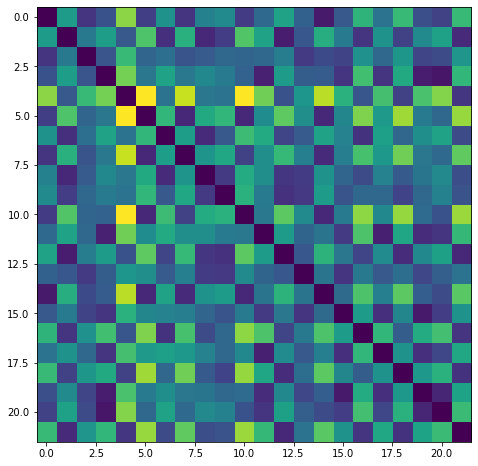

In [66]:
mD = matriz_distancias(Dx, distancia_euclidiana)
print('Tamaño de la matriz distancias (para cada elemento del dataset): ', mD.shape)
plt.imshow(mD, vmin=0, vmax=mD.max())

Paso número 20
Indice de los clusters que coinciden mejor: 86
Índices de los clusters a unir (i, j): (3, 20)
Cluster 3 y 20 asignados a etiqueta 3
Paso número 19
Indice de los clusters que coinciden mejor: 334
Índices de los clusters a unir (i, j): (15, 19)
Cluster 15 y 19 asignados a etiqueta 15
Paso número 18
Indice de los clusters que coinciden mejor: 14
Índices de los clusters a unir (i, j): (0, 14)
Cluster 0 y 14 asignados a etiqueta 0
Paso número 17
Indice de los clusters que coinciden mejor: 31
Índices de los clusters a unir (i, j): (1, 12)
Cluster 1 y 12 asignados a etiqueta 1
Paso número 16
Indice de los clusters que coinciden mejor: 67
Índices de los clusters a unir (i, j): (3, 13)
Cluster 3 y 13 asignados a etiqueta 3
Paso número 15
Indice de los clusters que coinciden mejor: 201
Índices de los clusters a unir (i, j): (11, 14)
Cluster 11 y 14 asignados a etiqueta 11
Paso número 14
Indice de los clusters que coinciden mejor: 59
Índices de los clusters a unir (i, j): (3, 11)
C

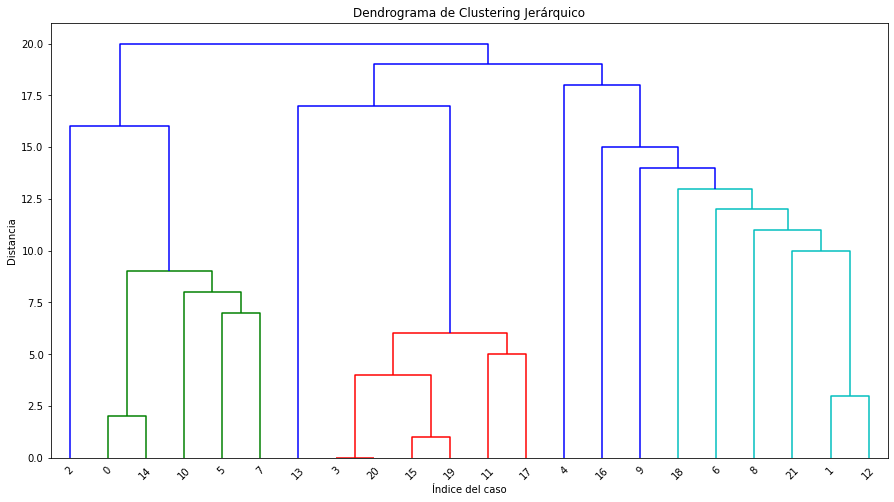

In [67]:
# usando el criterio de disimilitud mínima
mParticiones_min = clustering_aglomerativo(mD, disimilitud_minima)
plot_dendrograma_de_mparticiones(mD, mParticiones_min)

Paso número 20
Indice de los clusters que coinciden mejor: 86
Índices de los clusters a unir (i, j): (3, 20)
Cluster 3 y 20 asignados a etiqueta 3
Paso número 19
Indice de los clusters que coinciden mejor: 334
Índices de los clusters a unir (i, j): (15, 19)
Cluster 15 y 19 asignados a etiqueta 15
Paso número 18
Indice de los clusters que coinciden mejor: 14
Índices de los clusters a unir (i, j): (0, 14)
Cluster 0 y 14 asignados a etiqueta 0
Paso número 17
Indice de los clusters que coinciden mejor: 31
Índices de los clusters a unir (i, j): (1, 12)
Cluster 1 y 12 asignados a etiqueta 1
Paso número 16
Indice de los clusters que coinciden mejor: 213
Índices de los clusters a unir (i, j): (11, 15)
Cluster 11 y 15 asignados a etiqueta 11
Paso número 15
Indice de los clusters que coinciden mejor: 92
Índices de los clusters a unir (i, j): (5, 7)
Cluster 5 y 7 asignados a etiqueta 5
Paso número 14
Indice de los clusters que coinciden mejor: 103
Índices de los clusters a unir (i, j): (6, 7)
Clu

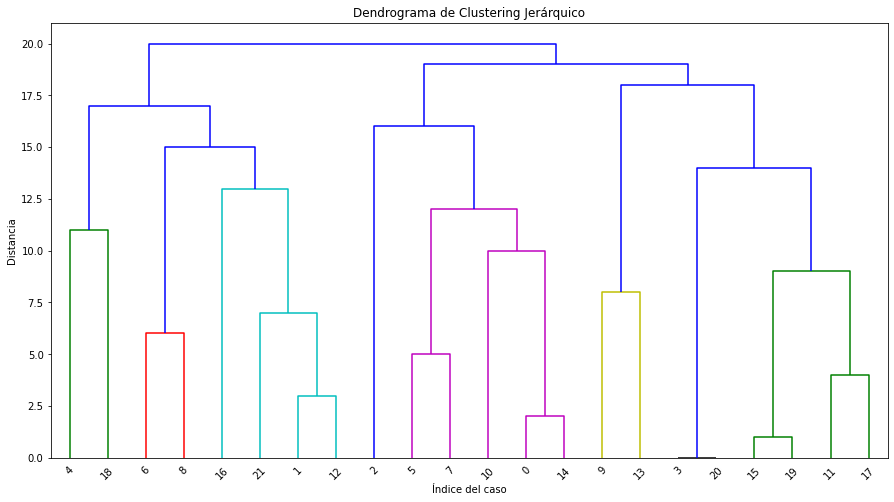

In [68]:
# usando el criterio de disimilitud máxima
mParticiones_max = clustering_aglomerativo(mD, disimilitud_maxima)
plot_dendrograma_de_mparticiones(mD, mParticiones_max)

Paso número 20
Indice de los clusters que coinciden mejor: 86
Índices de los clusters a unir (i, j): (3, 20)
Cluster 3 y 20 asignados a etiqueta 3
Paso número 19
Indice de los clusters que coinciden mejor: 334
Índices de los clusters a unir (i, j): (15, 19)
Cluster 15 y 19 asignados a etiqueta 15
Paso número 18
Indice de los clusters que coinciden mejor: 14
Índices de los clusters a unir (i, j): (0, 14)
Cluster 0 y 14 asignados a etiqueta 0
Paso número 17
Indice de los clusters que coinciden mejor: 31
Índices de los clusters a unir (i, j): (1, 12)
Cluster 1 y 12 asignados a etiqueta 1
Paso número 16
Indice de los clusters que coinciden mejor: 213
Índices de los clusters a unir (i, j): (11, 15)
Cluster 11 y 15 asignados a etiqueta 11
Paso número 15
Indice de los clusters que coinciden mejor: 92
Índices de los clusters a unir (i, j): (5, 7)
Cluster 5 y 7 asignados a etiqueta 5
Paso número 14
Indice de los clusters que coinciden mejor: 31
Índices de los clusters a unir (i, j): (1, 15)
Clu

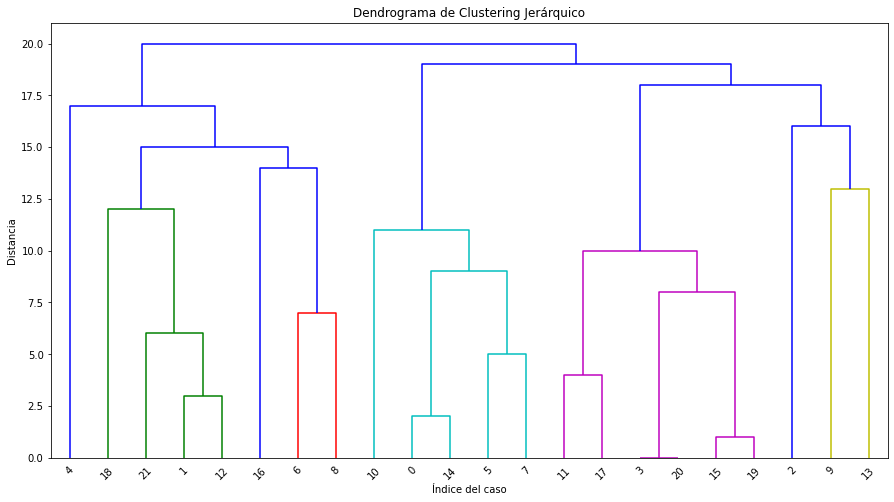

In [69]:
# usando el criterio de disimilitud media
mParticiones_mean = clustering_aglomerativo(mD, disimilitud_media)
plot_dendrograma_de_mparticiones(mD, mParticiones_mean)


La función plot_particiones permite observar cómo son las diferentes particiones (niveles del clustering jerárquico) mostrando el dataset original con la asignación a clústeres descrita mediante colores: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


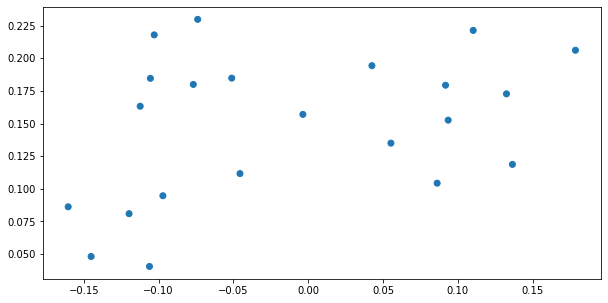

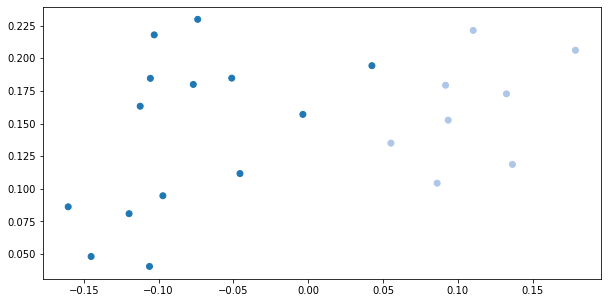

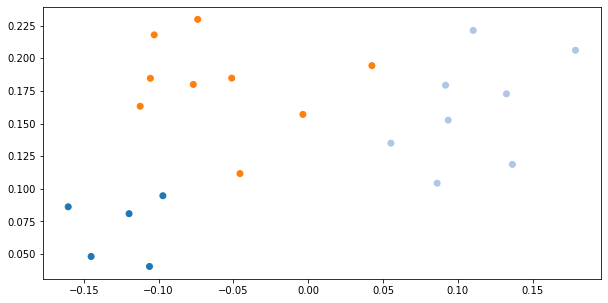

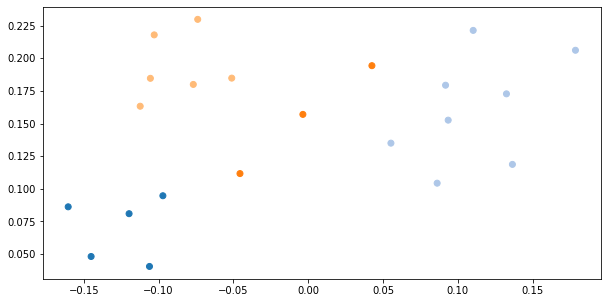

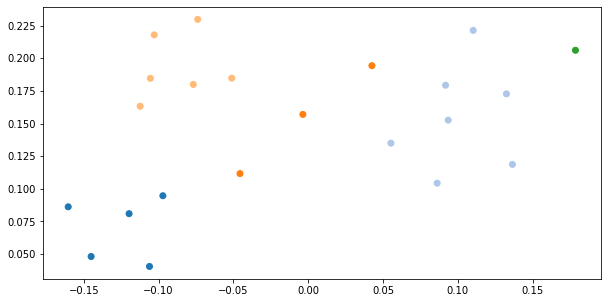

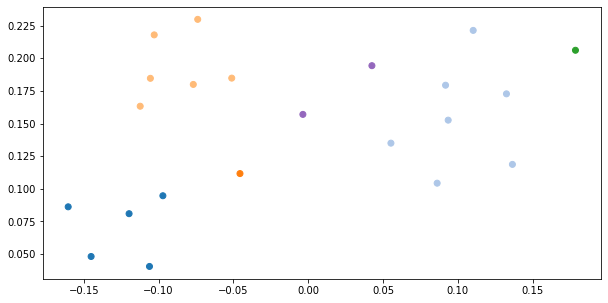

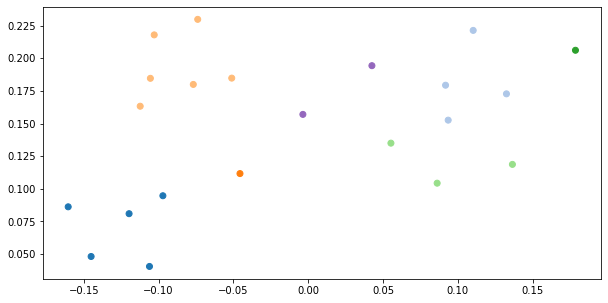

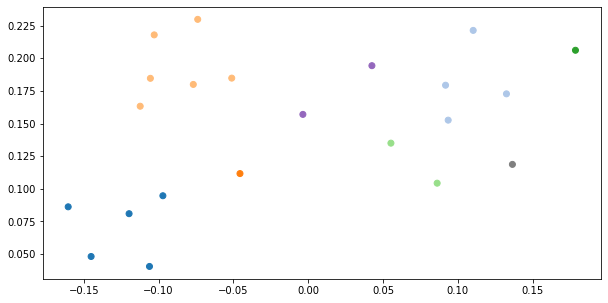

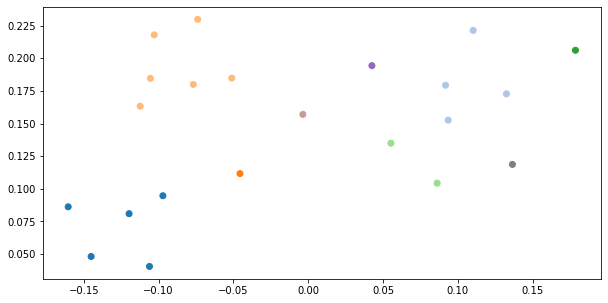

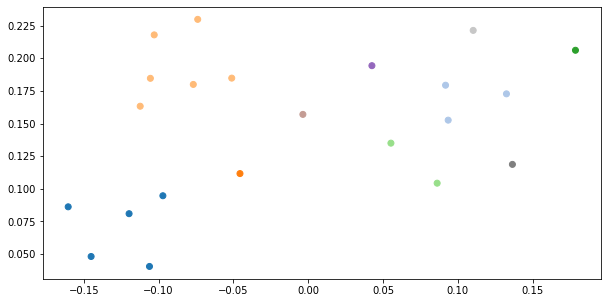

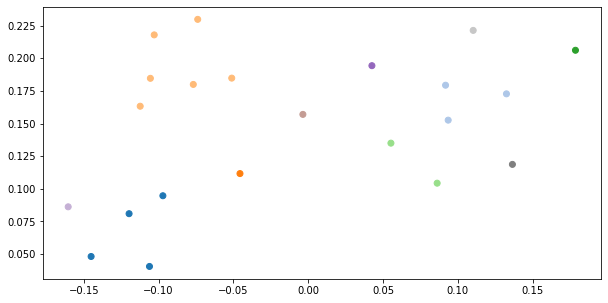

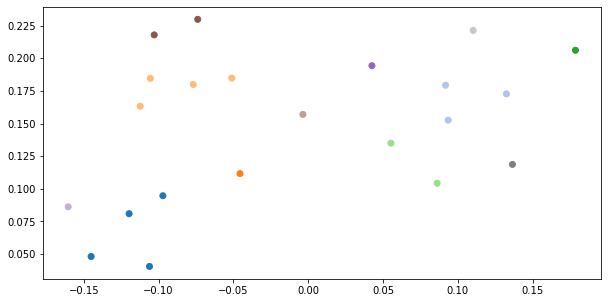

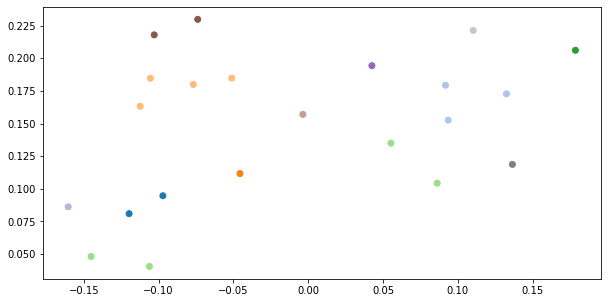

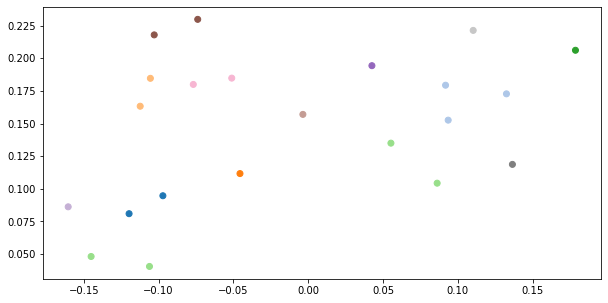

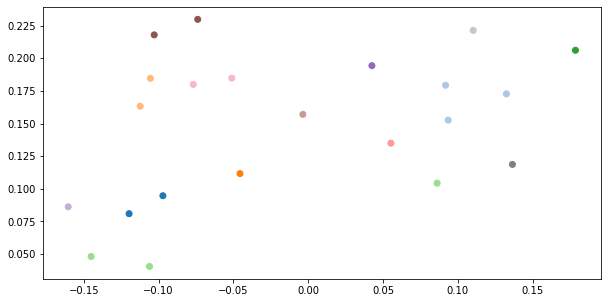

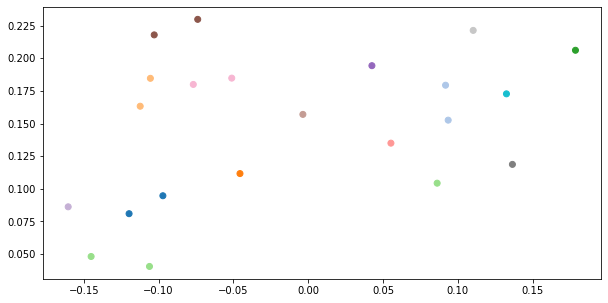

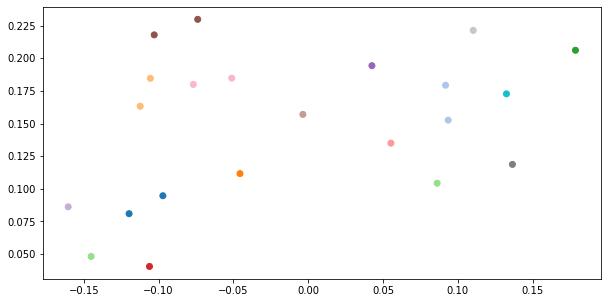

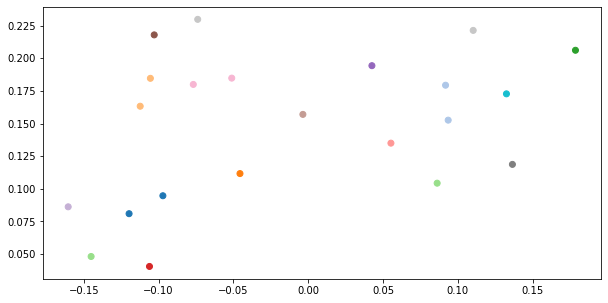

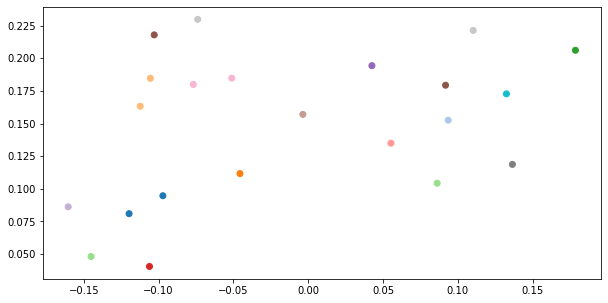

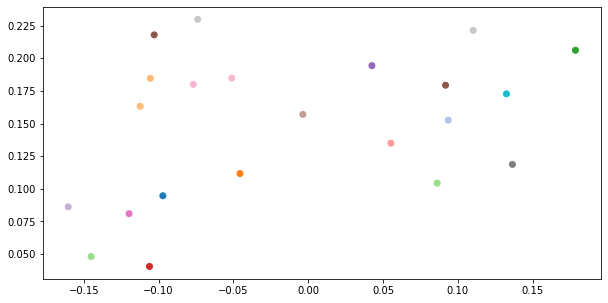

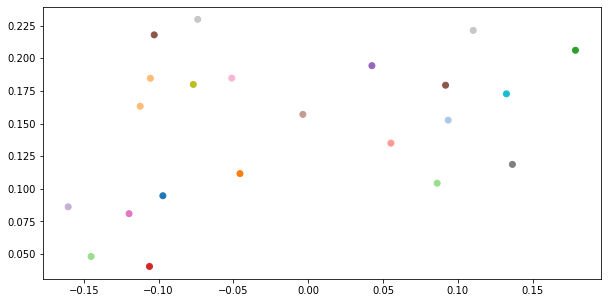

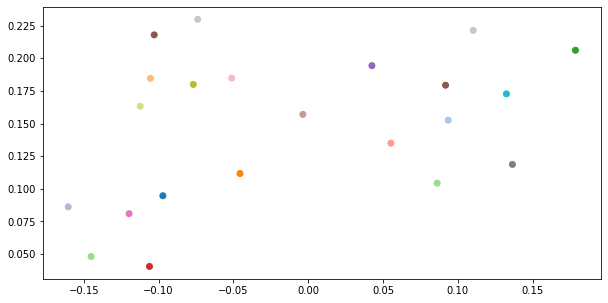

In [70]:
plot_particiones(Dx, mParticiones_mean)


El clustering jerárquico devuelve un espectro de agrupamientos. Muchas veces, es necesario seleccionar una única partición. Dada la matriz mParticiones, esto equivalente a quedarse con una de las columnas. Si queremos seleccionar una partición donde hayan K clústeres, debemos seleccionar la columna K-1. Así, podemos calcular el valor de una métrica de evaluación cualquiera. En este caso, usamos las métricas de ancho de silueta y de Calinski Harabaz:


In [74]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Queremos visualizar el clustering conseguido con K = 4. Como hemos visto
# anteriormente, los clusterings con diferentes K se encuentran en las columnas
# de mParticiones. Como queremos el clustering con K = 4, necesitamos la columna
# K-1. 
# Podemos elegir mParticiones_{min/max/mean}
mParticiones = mParticiones_mean
K = 4

# P6
partToEval = mParticiones[:, K-1]

print('La medida de Silueta con K =',K,'es',silhouette_score(Dx, partToEval))
print('La medida de Calinski Harabaz con K =',K,'es',calinski_harabasz_score(Dx, partToEval))

La medida de Silueta con K = 4 es 0.4408872869802952
La medida de Calinski Harabaz con K = 4 es 39.06472472659191



Podríamos incluso dibujar de manera sencilla la figura del codo recorriendo todas las columnas:


Text(0, 0.5, 'Medida de Calinski Harabaz')

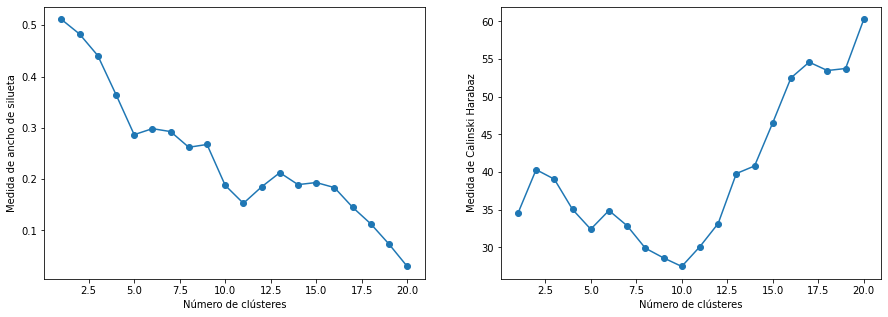

In [75]:
rsilueta = np.zeros(mParticiones.shape[1])
rch = np.zeros(mParticiones.shape[1])
for K in np.arange(1,mParticiones.shape[1]-1):
    rsilueta[K] = silhouette_score(Dx, mParticiones[:,K])
    rch[K] = calinski_harabasz_score(Dx, mParticiones[:,K])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,mParticiones.shape[1]-1), rsilueta[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot(np.arange(1,mParticiones.shape[1]-1), rch[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de Calinski Harabaz")


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering jerárquico aglomerativo. 

Están implementados (parámetro linkage) los criterios estudiados en teoría (disimilitud mínima : 'single'; máxima: 'complete'; y media: 'average') y muchos más.


In [76]:
from sklearn.cluster import AgglomerativeClustering

modelo = AgglomerativeClustering(linkage="single")
modelo = modelo.fit(Dx)

modelo = AgglomerativeClustering(linkage="complete")
modelo = modelo.fit(Dx)

modelo = AgglomerativeClustering(linkage="average")
modelo = modelo.fit(Dx)



 En cambio, para mostrar el dendrograma, tenemos que usar la library scipy:


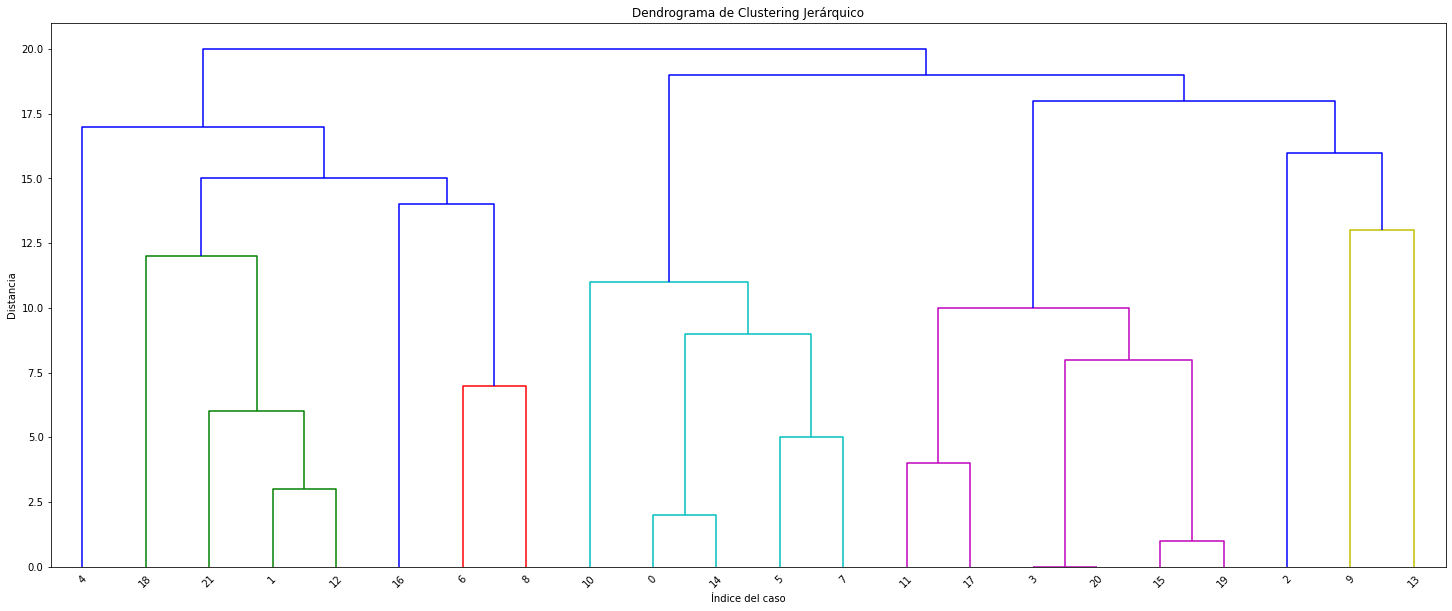

In [77]:
# Creamos la matriz de enlaces que necesita el método dendrogram de scipy
uniones = modelo.children_
# Las distancias y los tamaños, en esta ocasión, los asignamos de manera 
# inocua para no alterar el resultado (no disponemos de la información completa)
distancias = np.arange(uniones.shape[0])
tamanyos = np.arange(2, uniones.shape[0]+2)
mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

plt.figure(figsize=(25, 10))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(mEnlaces)
plt.show()


Probablemente, la librería más completa para hacer clustering jerárquico aglomerativo es scipy. La función linkage es la encargada de hacer el agrupamiento jerárquico. 


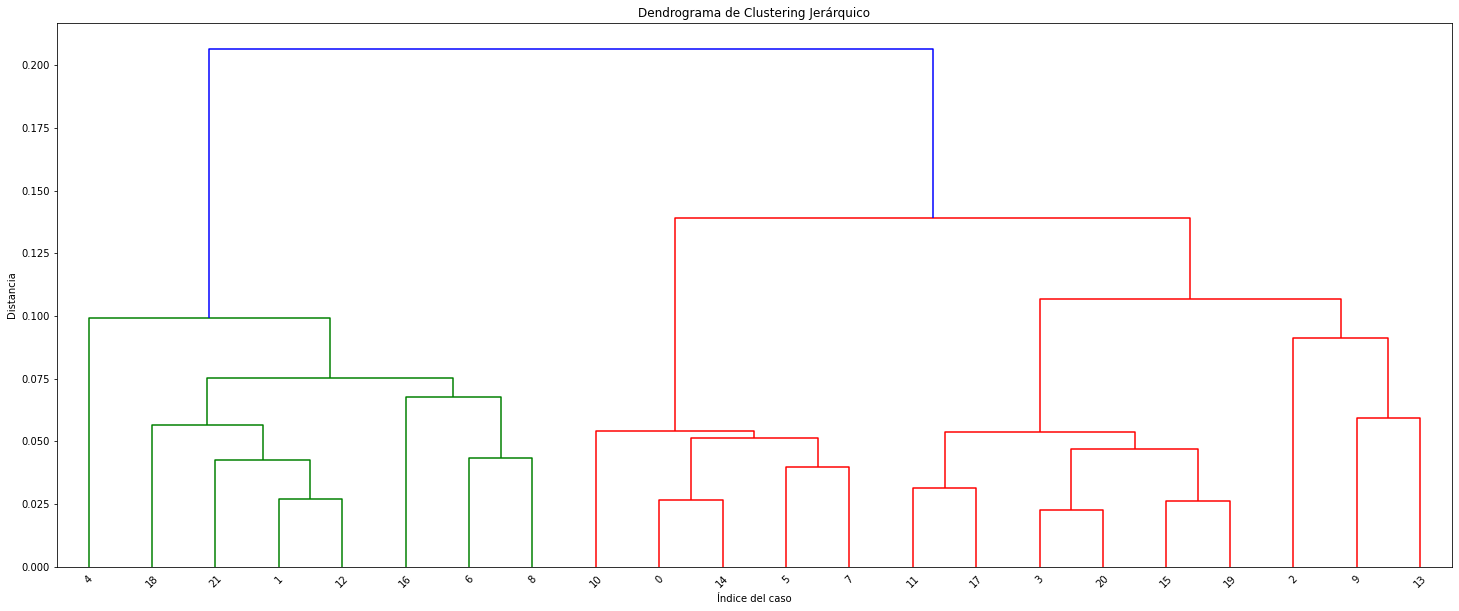

In [78]:
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree

# Podéis hacer pruebas comentando y descomentando
#modelo = linkage(Dx, 'single')   # disimilitud mínima
#modelo = linkage(Dx, 'complete') # disimilitud máxima
modelo = linkage(Dx, 'average')  # disimilitud media

plt.figure(figsize=(25, 10))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo)
plt.show()


La función `cut_tree` permite obtener una partición concreta dado un número de clústeres `K`. Es lo equivalente a quedarnos con la columna K - 1 de nuestra `mParticiones`.


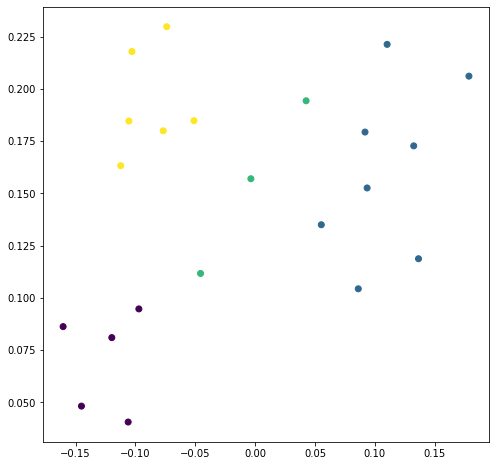

In [79]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters=4).flatten())
plt.show()


Con la siguiente función dibujaremos los resultados del clustering (fijado un K) usando diferentes criterios de unión. Podemos usar diferentes datasets de ejemplo (ver aquellos que tiene 2 dimensiones en:
https://github.com/flifuehu/viu-unsupervised-learning/tree/master/datasets)

Podemos hacer unas pruebas para ganar algunas intuiciones sobre cuál es la mejor estrategia según el tipo de datos...


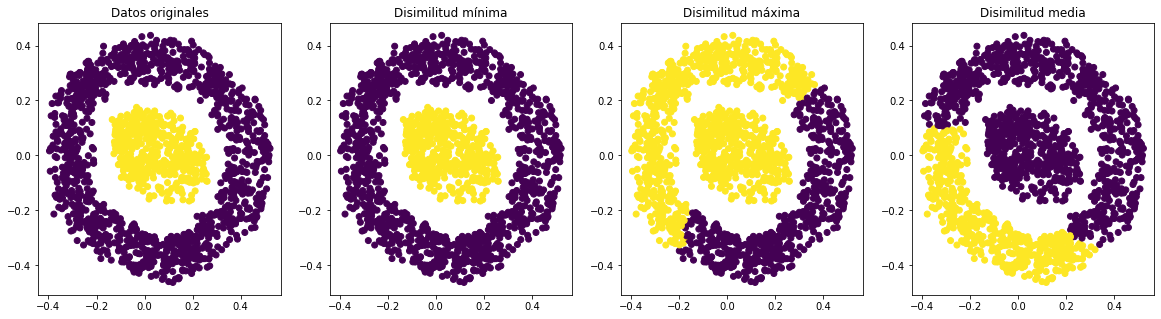

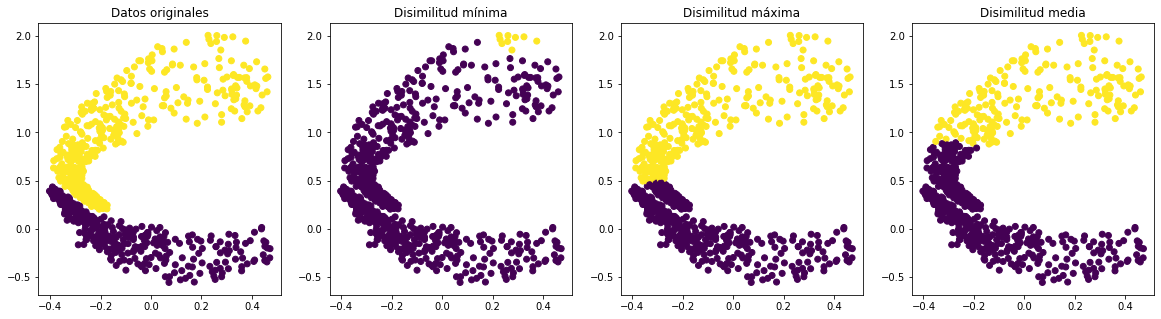

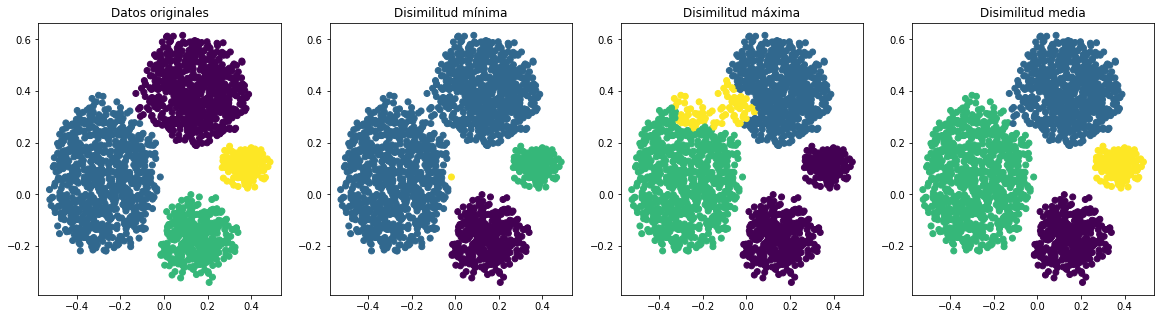

In [80]:
def plot_varios(Dx,Dy,K):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0].set_title('Datos originales')

    modelo = linkage(Dx, 'single')
    ax[1].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[1].set_title('Disimilitud mínima')
    
    modelo = linkage(Dx, 'complete')
    ax[2].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[2].set_title('Disimilitud máxima')
    
    modelo = linkage(Dx, 'average')
    ax[3].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[3].set_title('Disimilitud media')

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_circulos_concentricos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

plot_varios(Dx,Dy,2)


data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_dos_remolinos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

plot_varios(Dx,Dy,2)


data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

plot_varios(Dx,Dy,4)

# Clustering jerárquico divisivo

Vamos a ver ahora el funcionamiento y la utilización del clústering jerárquico divisivo.

Para empezar, cargamos las librerías que vamos a necesitar:

In [81]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree


Para comenzar, cargamos el conjunto de datos con el que trabajaremos:


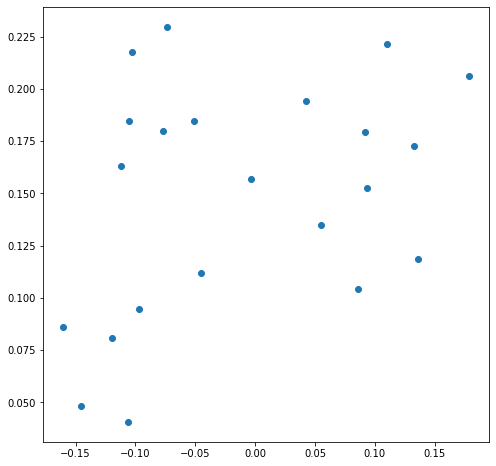

In [82]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_reducido.csv'
Dx = np.array(pd.read_csv(data_file_url,header=0))
Dx = Dx[ np.random.choice(np.arange(Dx.shape[0]), Dx.shape[0], replace=False) ,:]

plt.scatter(Dx[:,0], Dx[:,1])
plt.show()

Es el mismo dataset que usamos en el apartado anterior. Lo volveremos a usar ahora para estudiar las diferentes variantes del clústering divisivo. Empezamos nuevamente calculando la matriz de distancias, para lo que necesitaremos otra vez la función `matriz_distancias`.


In [83]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD


Necesitamos una función que, dada una matriz de distancias, construya un clustering divisivo. Es decir, partiendo de un único clúster (con todos los ejemplos de entrenamiento), se van dividiendo en dos iterativamente hasta que finalmente todos los elementos tienen su propio clúster unitario. En cada paso, el clúster a dividir se escoge como aquél que maximiza la disimilitud intraclúster (que puede ser definida de acuerdo a diferentes criterios). El clúster escogido se divide de acuerdo a cierto procedimiento de separación.

Sabemos que el número de divisiones es igual a `n-1` (el número de ejemplos menos uno). En la siguiente función, vamos guardando en cada columna de la matriz `mParticiones` la partición en clústeres de los ejemplos: cada partición `mParticiones[:, p]`, de longitud `n`, guarda el clúster al que pertenece el i-*ésimo* ejemplo en la posición `mParticiones[i, p]`. 

Para rellenar esa matriz, en cada paso (división), se calcula la disimilitud intraclúster de todos los clústeres usando el criterio elegido y se elige un clúster a dividir (`iClusterADiv`). Después, se aplica el procedimiento de separación elegido para obtener un subconjunto de elementos de ese clúster que pasan a formar parte de un nuevo clúster (se les asigna al clúster con índice `n`). 

Este procedimiento iterativo se repite hasta que sólo quedan clústeres unitarios (cada clúster tiene un único elemento) en el paso final:


In [93]:
def clustering_divisivo(mD, disimilitud_intracluster, separador, **kwargs):
    # En esta matriz almacenaremos las sucesivas particiones (clusterings) de los
    # datos. Sucesivas, porque cada paso del bucle de abajo realizará una separación
    # entre los dos clusters más diferentes, hasta que haya un cluster por elemento
    # del dataset.
    mParticiones = np.zeros((mD.shape[0], mD.shape[0]), dtype = np.int8)

    # Recorremos `mParticiones` (en esta ocasión, de manera creciente) guardando
    # los agrupamientos
    for n in range(1, mParticiones.shape[1]):
        print(f'Paso número {n}')
        
        # Al empezar, asignamos el agrupamiento anterior al actual, ya que el
        # agrupamiento en el momento anterior (`n-1`) únicamente sufrirá alguna 
        # modificación para dividir los dos clusters más separados.
        mParticiones[:,n] = mParticiones[:,n-1]

        # Calculamos la disimilitud intracluster
        rDisIntraCluster = disimilitud_intracluster(mD, mParticiones[:, n], n)

        # Y escogemos el cluster en el que mayor sea
        
        # P7
        iClusterADiv = np.argmax(rDisIntraCluster)

        print(f'Cluster a dividir: {iClusterADiv}')

        # Separamos dicho cluster en 2 sub-clusters siguiendo el criterio escogido
        iAClusterNuevo = separador(mD, mParticiones[:, n], iClusterADiv, **kwargs)
        print(f'Número de elementos a asignar al nuevo cluster {n}: {len(iAClusterNuevo)}')

        mParticiones[iAClusterNuevo, n] = n

    return mParticiones


Como se comentaba anteriormente, la primera decisión a tomar es qué clúster se va a dividir. Para ello se evalúa la disimilitud intraclúster. Hay diferentes maneras de medir dicha disimilitud. Una de ellas es mediante el <b>diámetro</b> del clúster, que se define como la máxima distancia entre dos elementos cualquiera del clúster. La siguiente función calcula dicho valor (diámetro) para todos los clústeres y los devuelve en un array:


In [94]:
def disimilitud_diametro(mD, particion, n):
    res = [ np.max((mD[ np.ix_(particion == pn , particion == pn) ] +
                    np.transpose(mD[ np.ix_(particion == pn , particion == pn) ]))/ 2)
           for pn in np.arange(n)]
    return res


Otra manera de calcular la disimilitud intraclúster es usando la <b>disimilitud media</b> del clúster, que se define como la distancia media entre todos los pares de elementos del clúster. La siguiente función calcula dicha disimilitud para todos los clústeres y los devuelve en un array: 


In [95]:
def disimilitud_media(mD, particion, n):
    res = [np.sum(mD[ np.ix_(particion == pn , particion == pn) ])
                              / (np.sum(particion == pn)**2)
                              for pn in np.arange(n)]
    return res


Una vez identificado el clúster que queremos dividir, el siguiente objetivo es saber cómo lo vamos a dividir. Para ello, se pueden aplicar también diferentes procedimientos.

El procedimiento propuesto por Macnaughton y Smith consiste en identificar, inicialmente, el ejemplo del clúster con mayor diferencia media con respecto al resto de elementos del clúster. Éste será el primer ejemplo que se separa del clúster. A partir se ese momento, de manera iterativa, se van separando nuevos elementos del primer clúster (original) y se incluyen en el nuevo grupo. En cada paso, el ejemplo que se traspasa es aquel que tiene menor distancia media con los elementos del nuevo clúster con respecto a la distancia media con los otros elementos que todavía están en el clúster original. Este traspaso se repite hasta que no haya ningún elemento en el clúster original que esté más cerca (en media) a los elementos del otro clúster que a los del suyo propio.


In [96]:
def separacion_macnaughton_smith(mDglobal, particion, iCluster):
    indsClust = np.where(particion==iCluster)[0]
    mD = mDglobal[ np.ix_(indsClust , indsClust)]
    
    SA = np.array([np.argmax(1/((mD.shape[0]-1)*2)*(np.sum(mD,axis=0)+np.sum(mD,axis=1)))])
    SB = np.delete(np.arange(mD.shape[0]), SA)
    if (SB.size == 1):
        return indsClust[SA]

    while True:
        res = np.zeros(SB.size)
        # Para todos los elementos del cluster original SB
        for i in np.arange(SB.size):
            SBa = np.delete(SB,i) 
            res[i] = (# distancia media con los otros elementos de SB
                np.sum(mD[ SB[i] , SBa ]) + 
                np.sum(mD[ SBa , SB[i] ])
            ) / (2 * SBa.size) - (# distancia media con los elementos ya movidos a SA
                np.sum(mD[ SB[i] , SA ]) +
                np.sum(mD[ SA , SB[i] ])
            ) / (2 * SA.size)


        # Si en todos los casos (todas las posiciones del vector res) la distancia 
        # es negativa quiere decir que no existe ningún elemento en SB más cercano 
        # a SA que al resto de SB
        if np.all(res < 0):
            break

        iToChange = np.argmax(res)
        SA = np.sort(np.append(SA, SB[iToChange]))
        SB = np.delete(np.arange(mD.shape[0]), SA)

    # Devolveremos los índices de los elementos que pertenecerán 
    # al clúster SA
    return indsClust[SA]


Otra manera de realizar la separación del clúster en dos es mediante el algoritmo K-means con K=2. Así se obtienen dos clústeres (a partir del clúster original) de manera rápida y utilizando éste popular algoritmo.


In [97]:
def separacion_Kmeans(mDglobal, particion, iCluster, Dxglobal):
    indsClust = np.where(particion==iCluster)[0]
    Dx = Dxglobal[indsClust,:]
    
    # P8
    modelo = KMeans(n_clusters=2, random_state=0)
    modelo = modelo.fit(Dx)
    Dyp = modelo.predict(Dx)

    # Devolveremos los índices de los ejemplos asignados 
    # al segundo clúster
    return indsClust[Dyp==1]


Finalmente, incluimos las funciones que nos permiten visualizar los resultados:


In [98]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
    cmap = get_cmap('tab20')
    vals = np.arange(Dx.shape[0]+2)/(Dx.shape[0]+2)
    rgba = cmap(vals[np.arange(Dx.shape[0])+1])

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1], c=rgba[mParticiones[:,K-1],:])

# Muestra el plot de todas las particiones posibles de la jerarquía
def plot_particiones(Dx, mParticiones):
    for k in np.arange(mParticiones.shape[1]):
        plot_particion_K(Dx, mParticiones,k+1)

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (    
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(15, 8))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()


Ahora ya estamos en disposición de realizar el clustering jerárquico divisivo. Empezaremos por calcular la matriz de distancias y, por este orden, calcularemos y mostraremos el dendrograma de los diferentes agrupamientos obtenidos de usar el criterio de disimilitud media y diámetro, en combinación con la separación de Macnaughton-Smith y la de K-means. También mostraremos (plotear) las respectivas particiones con 5 clústeres: 


Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 10
Paso número 2
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 2: 6
Paso número 3
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 3: 4
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 1
Paso número 5
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 5: 2
Paso número 6
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 6: 1
Paso número 7
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 7: 1
Paso número 8
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 8: 2
Paso número 9
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 9: 2
Paso número 10
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 11: 1
Paso número 12
Cluster a dividir: 0
Nú

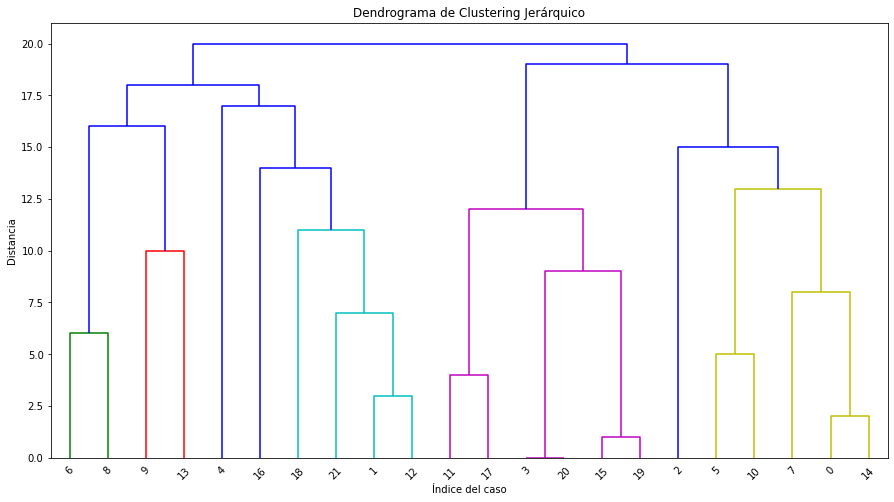

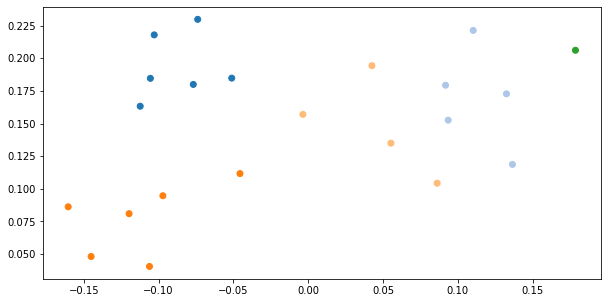

In [99]:
mD = matriz_distancias(Dx, distancia_euclidiana)
K = 5 # parametro para mostrar una particion

# Usando disimilitud media y el método de separacion de Macnaughton-Smith
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_macnaughton_smith)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 10
Paso número 2
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 2: 6
Paso número 3
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 3: 4
Paso número 4
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 4: 1
Paso número 5
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 5: 1
Paso número 6
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 6: 1
Paso número 7
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 7: 2
Paso número 8
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 8: 2
Paso número 9
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 9: 2
Paso número 10
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 11: 2
Paso número 12
Cluster a dividir: 3
Nú

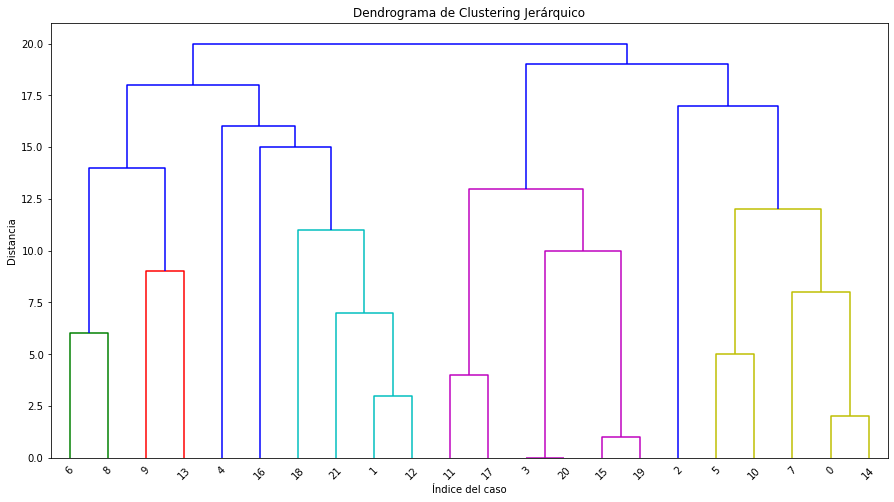

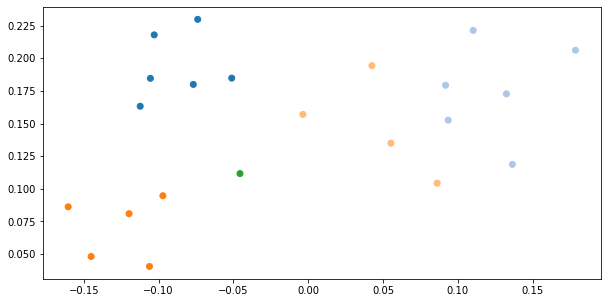

In [100]:
# Usando disimilitud diámetro y el método de separacion de Macnaughton-Smith
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_macnaughton_smith)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 13
Paso número 2
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 2: 5
Paso número 3
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 3: 3
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 2
Paso número 5
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 5: 4
Paso número 6
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 6: 2
Paso número 7
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 7: 3
Paso número 8
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 8: 2
Paso número 9
Cluster a dividir: 5
Número de elementos a asignar al nuevo cluster 9: 1
Paso número 10
Cluster a dividir: 4
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 11: 2
Paso número 12
Cluster a dividir: 5
Nú

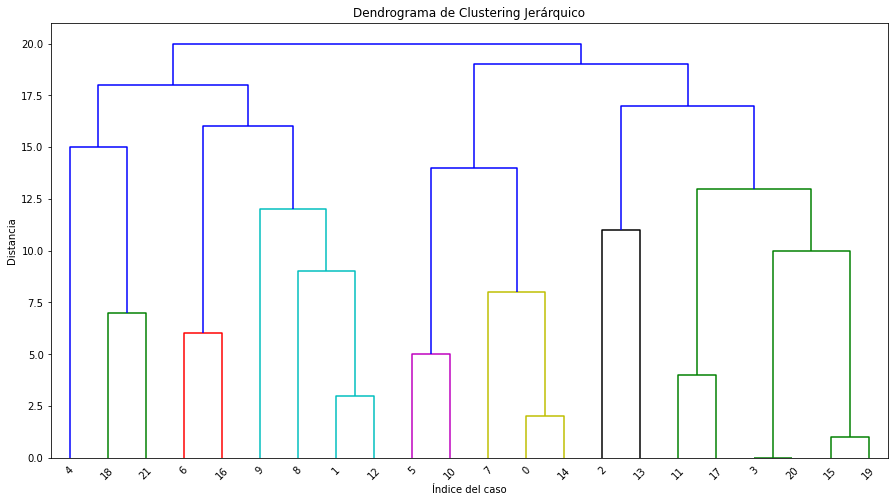

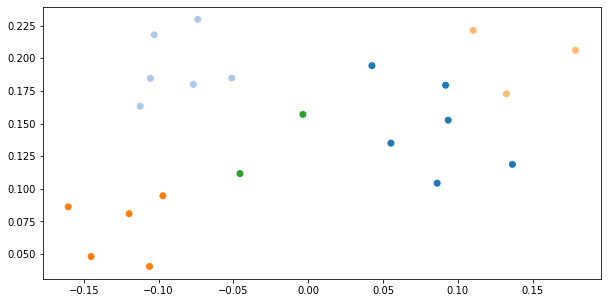

In [101]:
# Usando disimilitud media y K-means como método de separacion
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_Kmeans, Dxglobal=Dx)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 13
Paso número 2
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 2: 5
Paso número 3
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 3: 3
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 2
Paso número 5
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 5: 4
Paso número 6
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 6: 2
Paso número 7
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 7: 3
Paso número 8
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 8: 2
Paso número 9
Cluster a dividir: 5
Número de elementos a asignar al nuevo cluster 9: 1
Paso número 10
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 10: 2
Paso número 11
Cluster a dividir: 4
Número de elementos a asignar al nuevo cluster 11: 1
Paso número 12
Cluster a dividir: 5
Nú

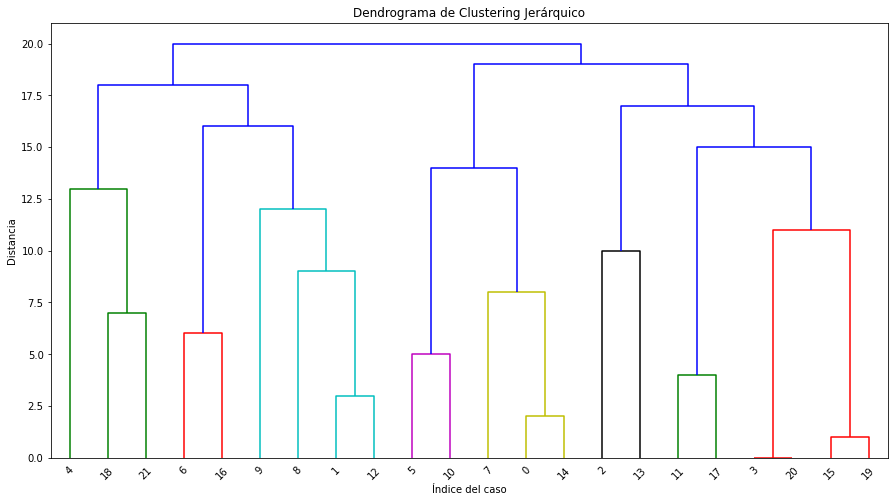

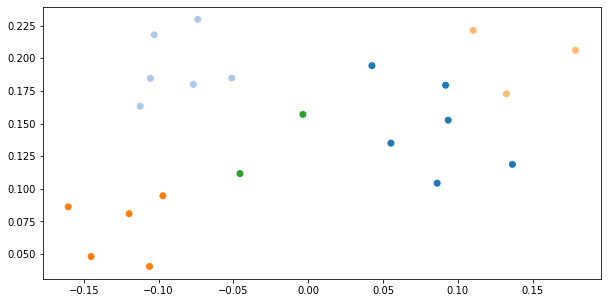

In [102]:
# Usando disimilitud diámetro y K-means como método de separacion
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_Kmeans, Dxglobal=Dx)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

<hr>
<h2>Implementaciones en librerías de Python</h2>

Dada la complejidad añadida del clustering jerárquico divisivo (respecto al aglomerativo), las principales librarías de aprendizaje automático de Python <b>no implementan</b> esta versión del agrupamiento jerárquico.
